In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 77xb9byl


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-77xb9byl:best, 58.49MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                           | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                                                                                   | 1/2604 [00:01<47:16,  1.09s/it]

  0%|▎                                                                                                                                                  | 6/2604 [00:01<06:40,  6.49it/s]

  0%|▌                                                                                                                                                 | 11/2604 [00:01<03:30, 12.33it/s]

  1%|▉                                                                                                                                                 | 16/2604 [00:01<02:23, 18.06it/s]

  1%|█▏                                                                                                                                                | 21/2604 [00:01<01:50, 23.37it/s]

  1%|█▍                                                                                                                                                | 26/2604 [00:01<01:32, 28.00it/s]

  1%|█▋                                                                                                                                                | 31/2604 [00:01<01:20, 31.85it/s]

  1%|██                                                                                                                                                | 36/2604 [00:01<01:13, 34.92it/s]

  2%|██▎                                                                                                                                               | 41/2604 [00:02<01:08, 37.27it/s]

  2%|██▌                                                                                                                                               | 46/2604 [00:02<01:05, 39.05it/s]

  2%|██▊                                                                                                                                               | 51/2604 [00:02<01:03, 40.36it/s]

  2%|███▏                                                                                                                                              | 56/2604 [00:02<01:01, 41.30it/s]

  2%|███▍                                                                                                                                              | 61/2604 [00:02<01:00, 42.00it/s]

  3%|███▋                                                                                                                                              | 66/2604 [00:02<00:59, 42.49it/s]

  3%|███▉                                                                                                                                              | 71/2604 [00:02<00:59, 42.82it/s]

  3%|████▎                                                                                                                                             | 76/2604 [00:02<00:59, 42.62it/s]

  3%|████▌                                                                                                                                             | 81/2604 [00:02<00:58, 42.91it/s]

  3%|████▊                                                                                                                                             | 86/2604 [00:03<00:58, 43.11it/s]

  3%|█████                                                                                                                                             | 91/2604 [00:03<00:58, 43.28it/s]

  4%|█████▍                                                                                                                                            | 96/2604 [00:03<00:57, 43.39it/s]

  4%|█████▌                                                                                                                                           | 101/2604 [00:03<00:57, 43.47it/s]

  4%|█████▉                                                                                                                                           | 106/2604 [00:03<00:57, 43.52it/s]

  4%|██████▏                                                                                                                                          | 111/2604 [00:03<00:57, 43.57it/s]

  4%|██████▍                                                                                                                                          | 116/2604 [00:03<00:57, 43.59it/s]

  5%|██████▋                                                                                                                                          | 121/2604 [00:03<00:56, 43.60it/s]

  5%|███████                                                                                                                                          | 126/2604 [00:03<00:56, 43.62it/s]

  5%|███████▎                                                                                                                                         | 131/2604 [00:04<00:56, 43.64it/s]

  5%|███████▌                                                                                                                                         | 136/2604 [00:04<00:56, 43.65it/s]

  5%|███████▊                                                                                                                                         | 141/2604 [00:04<00:56, 43.66it/s]

  6%|████████▏                                                                                                                                        | 146/2604 [00:04<00:56, 43.67it/s]

  6%|████████▍                                                                                                                                        | 151/2604 [00:04<00:56, 43.69it/s]

  6%|████████▋                                                                                                                                        | 156/2604 [00:04<00:56, 43.68it/s]

  6%|████████▉                                                                                                                                        | 161/2604 [00:04<00:55, 43.69it/s]

  6%|█████████▏                                                                                                                                       | 166/2604 [00:04<00:55, 43.67it/s]

  7%|█████████▌                                                                                                                                       | 171/2604 [00:04<00:55, 43.67it/s]

  7%|█████████▊                                                                                                                                       | 176/2604 [00:05<00:55, 43.68it/s]

  7%|██████████                                                                                                                                       | 181/2604 [00:05<00:55, 43.67it/s]

  7%|██████████▎                                                                                                                                      | 186/2604 [00:05<00:55, 43.67it/s]

  7%|██████████▋                                                                                                                                      | 191/2604 [00:05<00:55, 43.70it/s]

  8%|██████████▉                                                                                                                                      | 196/2604 [00:05<00:55, 43.68it/s]

  8%|███████████▏                                                                                                                                     | 201/2604 [00:05<00:55, 43.68it/s]

  8%|███████████▍                                                                                                                                     | 206/2604 [00:05<00:54, 43.67it/s]

  8%|███████████▋                                                                                                                                     | 211/2604 [00:05<00:54, 43.70it/s]

  8%|████████████                                                                                                                                     | 216/2604 [00:06<00:54, 43.68it/s]

  8%|████████████▎                                                                                                                                    | 221/2604 [00:06<00:54, 43.67it/s]

  9%|████████████▌                                                                                                                                    | 226/2604 [00:06<00:54, 43.68it/s]

  9%|████████████▊                                                                                                                                    | 231/2604 [00:06<00:54, 43.66it/s]

  9%|█████████████▏                                                                                                                                   | 236/2604 [00:06<00:54, 43.67it/s]

  9%|█████████████▍                                                                                                                                   | 241/2604 [00:06<00:54, 43.68it/s]

  9%|█████████████▋                                                                                                                                   | 246/2604 [00:06<00:53, 43.70it/s]

 10%|█████████████▉                                                                                                                                   | 251/2604 [00:06<00:53, 43.68it/s]

 10%|██████████████▎                                                                                                                                  | 256/2604 [00:06<00:53, 43.69it/s]

 10%|██████████████▌                                                                                                                                  | 261/2604 [00:07<00:53, 43.69it/s]

 10%|██████████████▊                                                                                                                                  | 266/2604 [00:07<00:53, 43.69it/s]

 10%|███████████████                                                                                                                                  | 271/2604 [00:07<00:53, 43.68it/s]

 11%|███████████████▎                                                                                                                                 | 276/2604 [00:07<00:53, 43.69it/s]

 11%|███████████████▋                                                                                                                                 | 281/2604 [00:07<00:53, 43.67it/s]

 11%|███████████████▉                                                                                                                                 | 286/2604 [00:07<00:53, 43.67it/s]

 11%|████████████████▏                                                                                                                                | 291/2604 [00:07<00:52, 43.68it/s]

 11%|████████████████▍                                                                                                                                | 296/2604 [00:07<00:52, 43.68it/s]

 12%|████████████████▊                                                                                                                                | 301/2604 [00:07<00:52, 43.67it/s]

 12%|█████████████████                                                                                                                                | 306/2604 [00:08<00:52, 43.68it/s]

 12%|█████████████████▎                                                                                                                               | 311/2604 [00:08<00:52, 43.68it/s]

 12%|█████████████████▌                                                                                                                               | 316/2604 [00:08<00:52, 43.69it/s]

 12%|█████████████████▊                                                                                                                               | 321/2604 [00:08<00:52, 43.65it/s]

 13%|██████████████████▏                                                                                                                              | 326/2604 [00:08<00:52, 43.65it/s]

 13%|██████████████████▍                                                                                                                              | 331/2604 [00:08<00:52, 43.66it/s]

 13%|██████████████████▋                                                                                                                              | 336/2604 [00:08<00:51, 43.67it/s]

 13%|██████████████████▉                                                                                                                              | 341/2604 [00:08<00:51, 43.68it/s]

 13%|███████████████████▎                                                                                                                             | 346/2604 [00:08<00:51, 43.68it/s]

 13%|███████████████████▌                                                                                                                             | 351/2604 [00:09<00:51, 43.70it/s]

 14%|███████████████████▊                                                                                                                             | 356/2604 [00:09<00:51, 43.70it/s]

 14%|████████████████████                                                                                                                             | 361/2604 [00:09<00:51, 43.67it/s]

 14%|████████████████████▍                                                                                                                            | 366/2604 [00:09<00:51, 43.69it/s]

 14%|████████████████████▋                                                                                                                            | 371/2604 [00:09<00:51, 43.70it/s]

 14%|████████████████████▉                                                                                                                            | 376/2604 [00:09<00:50, 43.71it/s]

 15%|█████████████████████▏                                                                                                                           | 381/2604 [00:09<00:50, 43.71it/s]

 15%|█████████████████████▍                                                                                                                           | 386/2604 [00:09<00:50, 43.70it/s]

 15%|█████████████████████▊                                                                                                                           | 391/2604 [00:10<00:50, 43.70it/s]

 15%|██████████████████████                                                                                                                           | 396/2604 [00:10<00:50, 43.72it/s]

 15%|██████████████████████▎                                                                                                                          | 401/2604 [00:10<00:50, 43.71it/s]

 16%|██████████████████████▌                                                                                                                          | 406/2604 [00:10<00:50, 43.68it/s]

 16%|██████████████████████▉                                                                                                                          | 411/2604 [00:10<00:50, 43.70it/s]

 16%|███████████████████████▏                                                                                                                         | 416/2604 [00:10<00:50, 43.71it/s]

 16%|███████████████████████▍                                                                                                                         | 421/2604 [00:10<00:49, 43.69it/s]

 16%|███████████████████████▋                                                                                                                         | 426/2604 [00:10<00:49, 43.70it/s]

 17%|███████████████████████▉                                                                                                                         | 431/2604 [00:10<00:49, 43.68it/s]

 17%|████████████████████████▎                                                                                                                        | 436/2604 [00:11<00:49, 43.71it/s]

 17%|████████████████████████▌                                                                                                                        | 441/2604 [00:11<00:49, 43.72it/s]

 17%|████████████████████████▊                                                                                                                        | 446/2604 [00:11<00:49, 43.71it/s]

 17%|█████████████████████████                                                                                                                        | 451/2604 [00:11<00:49, 43.85it/s]

 18%|█████████████████████████▍                                                                                                                       | 456/2604 [00:11<00:48, 44.59it/s]

 18%|█████████████████████████▋                                                                                                                       | 461/2604 [00:11<00:47, 45.17it/s]

 18%|█████████████████████████▉                                                                                                                       | 466/2604 [00:11<00:46, 45.57it/s]

 18%|██████████████████████████▏                                                                                                                      | 471/2604 [00:11<00:46, 45.86it/s]

 18%|██████████████████████████▌                                                                                                                      | 476/2604 [00:11<00:46, 46.06it/s]

 18%|██████████████████████████▊                                                                                                                      | 481/2604 [00:12<00:45, 46.21it/s]

 19%|███████████████████████████                                                                                                                      | 486/2604 [00:12<00:45, 46.31it/s]

 19%|███████████████████████████▎                                                                                                                     | 491/2604 [00:12<00:45, 46.38it/s]

 19%|███████████████████████████▌                                                                                                                     | 496/2604 [00:12<00:45, 46.43it/s]

 19%|███████████████████████████▉                                                                                                                     | 501/2604 [00:12<00:45, 46.48it/s]

 19%|████████████████████████████▏                                                                                                                    | 506/2604 [00:12<00:45, 46.49it/s]

 20%|████████████████████████████▍                                                                                                                    | 511/2604 [00:12<00:45, 46.48it/s]

 20%|████████████████████████████▋                                                                                                                    | 516/2604 [00:12<00:44, 46.49it/s]

 20%|█████████████████████████████                                                                                                                    | 521/2604 [00:12<00:44, 46.52it/s]

 20%|█████████████████████████████▎                                                                                                                   | 526/2604 [00:13<00:44, 46.53it/s]

 20%|█████████████████████████████▌                                                                                                                   | 531/2604 [00:13<00:44, 46.54it/s]

 21%|█████████████████████████████▊                                                                                                                   | 536/2604 [00:13<00:44, 46.54it/s]

 21%|██████████████████████████████                                                                                                                   | 541/2604 [00:13<00:44, 46.54it/s]

 21%|██████████████████████████████▍                                                                                                                  | 546/2604 [00:13<00:44, 46.54it/s]

 21%|██████████████████████████████▋                                                                                                                  | 551/2604 [00:13<00:44, 46.54it/s]

 21%|██████████████████████████████▉                                                                                                                  | 556/2604 [00:13<00:43, 46.55it/s]

 22%|███████████████████████████████▏                                                                                                                 | 561/2604 [00:13<00:43, 46.55it/s]

 22%|███████████████████████████████▌                                                                                                                 | 566/2604 [00:13<00:43, 46.56it/s]

 22%|███████████████████████████████▊                                                                                                                 | 571/2604 [00:13<00:43, 46.56it/s]

 22%|████████████████████████████████                                                                                                                 | 576/2604 [00:14<00:43, 46.51it/s]

 22%|████████████████████████████████▎                                                                                                                | 581/2604 [00:14<00:43, 46.53it/s]

 23%|████████████████████████████████▋                                                                                                                | 586/2604 [00:14<00:43, 46.54it/s]

 23%|████████████████████████████████▉                                                                                                                | 591/2604 [00:14<00:43, 46.55it/s]

 23%|█████████████████████████████████▏                                                                                                               | 596/2604 [00:14<00:43, 46.56it/s]

 23%|█████████████████████████████████▍                                                                                                               | 601/2604 [00:14<00:43, 46.56it/s]

 23%|█████████████████████████████████▋                                                                                                               | 606/2604 [00:14<00:42, 46.55it/s]

 23%|██████████████████████████████████                                                                                                               | 611/2604 [00:14<00:42, 46.56it/s]

 24%|██████████████████████████████████▎                                                                                                              | 616/2604 [00:14<00:42, 46.56it/s]

 24%|██████████████████████████████████▌                                                                                                              | 621/2604 [00:15<00:42, 46.56it/s]

 24%|██████████████████████████████████▊                                                                                                              | 626/2604 [00:15<00:42, 46.56it/s]

 24%|███████████████████████████████████▏                                                                                                             | 631/2604 [00:15<00:42, 46.55it/s]

 24%|███████████████████████████████████▍                                                                                                             | 636/2604 [00:15<00:42, 46.55it/s]

 25%|███████████████████████████████████▋                                                                                                             | 641/2604 [00:15<00:42, 46.55it/s]

 25%|███████████████████████████████████▉                                                                                                             | 646/2604 [00:15<00:42, 46.50it/s]

 25%|████████████████████████████████████▎                                                                                                            | 651/2604 [00:15<00:41, 46.51it/s]

 25%|████████████████████████████████████▌                                                                                                            | 656/2604 [00:15<00:41, 46.51it/s]

 25%|████████████████████████████████████▊                                                                                                            | 661/2604 [00:15<00:41, 46.53it/s]

 26%|█████████████████████████████████████                                                                                                            | 666/2604 [00:16<00:41, 46.53it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 671/2604 [00:16<00:41, 46.54it/s]

 26%|█████████████████████████████████████▋                                                                                                           | 676/2604 [00:16<00:41, 46.54it/s]

 26%|█████████████████████████████████████▉                                                                                                           | 681/2604 [00:16<00:41, 46.54it/s]

 26%|██████████████████████████████████████▏                                                                                                          | 686/2604 [00:16<00:41, 46.54it/s]

 27%|██████████████████████████████████████▍                                                                                                          | 691/2604 [00:16<00:41, 46.55it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 696/2604 [00:16<00:40, 46.55it/s]

 27%|███████████████████████████████████████                                                                                                          | 701/2604 [00:16<00:40, 46.55it/s]

 27%|███████████████████████████████████████▎                                                                                                         | 706/2604 [00:16<00:40, 46.56it/s]

 27%|███████████████████████████████████████▌                                                                                                         | 711/2604 [00:16<00:40, 46.55it/s]

 27%|███████████████████████████████████████▊                                                                                                         | 716/2604 [00:17<00:40, 46.56it/s]

 28%|████████████████████████████████████████▏                                                                                                        | 721/2604 [00:17<00:40, 46.57it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 726/2604 [00:17<00:40, 46.56it/s]

 28%|████████████████████████████████████████▋                                                                                                        | 731/2604 [00:17<00:40, 46.50it/s]

 28%|████████████████████████████████████████▉                                                                                                        | 736/2604 [00:17<00:40, 46.52it/s]

 28%|█████████████████████████████████████████▎                                                                                                       | 741/2604 [00:17<00:40, 46.53it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 746/2604 [00:17<00:39, 46.54it/s]

 29%|█████████████████████████████████████████▊                                                                                                       | 751/2604 [00:17<00:39, 46.55it/s]

 29%|██████████████████████████████████████████                                                                                                       | 756/2604 [00:17<00:39, 46.55it/s]

 29%|██████████████████████████████████████████▍                                                                                                      | 761/2604 [00:18<00:39, 46.55it/s]

 29%|██████████████████████████████████████████▋                                                                                                      | 766/2604 [00:18<00:39, 46.55it/s]

 30%|██████████████████████████████████████████▉                                                                                                      | 771/2604 [00:18<00:39, 46.56it/s]

 30%|███████████████████████████████████████████▏                                                                                                     | 776/2604 [00:18<00:39, 46.56it/s]

 30%|███████████████████████████████████████████▍                                                                                                     | 781/2604 [00:18<00:39, 46.56it/s]

 30%|███████████████████████████████████████████▊                                                                                                     | 786/2604 [00:18<00:39, 46.58it/s]

 30%|████████████████████████████████████████████                                                                                                     | 791/2604 [00:18<00:38, 46.59it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 796/2604 [00:18<00:38, 46.59it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 801/2604 [00:18<00:38, 46.59it/s]

 31%|████████████████████████████████████████████▉                                                                                                    | 806/2604 [00:19<00:39, 45.89it/s]

 31%|█████████████████████████████████████████████▏                                                                                                   | 811/2604 [00:19<00:39, 45.23it/s]

 31%|█████████████████████████████████████████████▍                                                                                                   | 816/2604 [00:19<00:39, 44.79it/s]

 32%|█████████████████████████████████████████████▋                                                                                                   | 821/2604 [00:19<00:40, 44.40it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 826/2604 [00:19<00:40, 44.19it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 831/2604 [00:19<00:40, 44.03it/s]

 32%|██████████████████████████████████████████████▌                                                                                                  | 836/2604 [00:19<00:40, 43.92it/s]

 32%|██████████████████████████████████████████████▊                                                                                                  | 841/2604 [00:19<00:40, 43.87it/s]

 32%|███████████████████████████████████████████████                                                                                                  | 846/2604 [00:19<00:40, 43.82it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 851/2604 [00:20<00:40, 43.79it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 856/2604 [00:20<00:39, 43.75it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 861/2604 [00:20<00:39, 43.74it/s]

 33%|████████████████████████████████████████████████▏                                                                                                | 866/2604 [00:20<00:39, 43.73it/s]

 33%|████████████████████████████████████████████████▌                                                                                                | 871/2604 [00:20<00:39, 43.71it/s]

 34%|████████████████████████████████████████████████▊                                                                                                | 876/2604 [00:20<00:39, 43.73it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 881/2604 [00:20<00:39, 43.72it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 886/2604 [00:20<00:39, 43.72it/s]

 34%|█████████████████████████████████████████████████▌                                                                                               | 891/2604 [00:20<00:39, 43.70it/s]

 34%|█████████████████████████████████████████████████▉                                                                                               | 896/2604 [00:21<00:39, 43.69it/s]

 35%|██████████████████████████████████████████████████▏                                                                                              | 901/2604 [00:21<00:38, 43.69it/s]

 35%|██████████████████████████████████████████████████▍                                                                                              | 906/2604 [00:21<00:38, 43.69it/s]

 35%|██████████████████████████████████████████████████▋                                                                                              | 911/2604 [00:21<00:38, 43.70it/s]

 35%|███████████████████████████████████████████████████                                                                                              | 916/2604 [00:21<00:38, 43.72it/s]

 35%|███████████████████████████████████████████████████▎                                                                                             | 921/2604 [00:21<00:38, 43.64it/s]

 36%|███████████████████████████████████████████████████▌                                                                                             | 926/2604 [00:21<00:38, 43.67it/s]

 36%|███████████████████████████████████████████████████▊                                                                                             | 931/2604 [00:21<00:38, 43.68it/s]

 36%|████████████████████████████████████████████████████                                                                                             | 936/2604 [00:22<00:38, 43.70it/s]

 36%|████████████████████████████████████████████████████▍                                                                                            | 941/2604 [00:22<00:38, 43.71it/s]

 36%|████████████████████████████████████████████████████▋                                                                                            | 946/2604 [00:22<00:37, 43.70it/s]

 37%|████████████████████████████████████████████████████▉                                                                                            | 951/2604 [00:22<00:37, 43.70it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 956/2604 [00:22<00:37, 43.69it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                           | 961/2604 [00:22<00:37, 43.69it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                           | 966/2604 [00:22<00:37, 43.70it/s]

 37%|██████████████████████████████████████████████████████                                                                                           | 971/2604 [00:22<00:37, 43.70it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                          | 976/2604 [00:22<00:37, 43.70it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                          | 981/2604 [00:23<00:37, 43.70it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                          | 986/2604 [00:23<00:37, 43.69it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                         | 991/2604 [00:23<00:36, 43.70it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                         | 996/2604 [00:23<00:36, 43.71it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                        | 1001/2604 [00:23<00:36, 43.73it/s]

 39%|███████████████████████████████████████████████████████▋                                                                                        | 1006/2604 [00:23<00:36, 43.71it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                        | 1011/2604 [00:23<00:36, 43.71it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                       | 1016/2604 [00:23<00:36, 43.71it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                       | 1021/2604 [00:23<00:36, 43.70it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                       | 1026/2604 [00:24<00:36, 43.72it/s]

 40%|█████████████████████████████████████████████████████████                                                                                       | 1031/2604 [00:24<00:35, 43.74it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                      | 1036/2604 [00:24<00:35, 43.75it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                      | 1041/2604 [00:24<00:35, 43.67it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                      | 1046/2604 [00:24<00:35, 43.68it/s]

 40%|██████████████████████████████████████████████████████████                                                                                      | 1051/2604 [00:24<00:35, 43.67it/s]

 41%|██████████████████████████████████████████████████████████▍                                                                                     | 1056/2604 [00:24<00:35, 43.68it/s]

 41%|██████████████████████████████████████████████████████████▋                                                                                     | 1061/2604 [00:24<00:35, 43.70it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                     | 1066/2604 [00:24<00:35, 43.73it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                    | 1071/2604 [00:25<00:35, 43.73it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                    | 1076/2604 [00:25<00:34, 43.72it/s]

 42%|███████████████████████████████████████████████████████████▊                                                                                    | 1081/2604 [00:25<00:34, 43.71it/s]

 42%|████████████████████████████████████████████████████████████                                                                                    | 1086/2604 [00:25<00:34, 43.69it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                   | 1091/2604 [00:25<00:34, 43.68it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                   | 1096/2604 [00:25<00:34, 43.71it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                   | 1101/2604 [00:25<00:34, 43.70it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                  | 1106/2604 [00:25<00:34, 43.69it/s]

 43%|█████████████████████████████████████████████████████████████▍                                                                                  | 1111/2604 [00:26<00:34, 43.70it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                  | 1116/2604 [00:26<00:34, 43.70it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                  | 1121/2604 [00:26<00:33, 43.68it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                 | 1126/2604 [00:26<00:33, 43.68it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                 | 1131/2604 [00:26<00:33, 43.70it/s]

 44%|██████████████████████████████████████████████████████████████▊                                                                                 | 1136/2604 [00:26<00:33, 43.71it/s]

 44%|███████████████████████████████████████████████████████████████                                                                                 | 1141/2604 [00:26<00:33, 43.71it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                | 1146/2604 [00:26<00:33, 43.72it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                | 1151/2604 [00:26<00:33, 43.72it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                | 1156/2604 [00:27<00:33, 43.71it/s]

 45%|████████████████████████████████████████████████████████████████▏                                                                               | 1161/2604 [00:27<00:33, 43.72it/s]

 45%|████████████████████████████████████████████████████████████████▍                                                                               | 1166/2604 [00:27<00:32, 43.72it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                               | 1171/2604 [00:27<00:32, 43.64it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                               | 1176/2604 [00:27<00:32, 43.68it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                              | 1181/2604 [00:27<00:32, 43.69it/s]

 46%|█████████████████████████████████████████████████████████████████▌                                                                              | 1186/2604 [00:27<00:32, 43.69it/s]

 46%|█████████████████████████████████████████████████████████████████▊                                                                              | 1191/2604 [00:27<00:32, 43.70it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                             | 1196/2604 [00:27<00:32, 43.72it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                             | 1201/2604 [00:28<00:32, 43.72it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                             | 1206/2604 [00:28<00:31, 43.71it/s]

 47%|██████████████████████████████████████████████████████████████████▉                                                                             | 1211/2604 [00:28<00:31, 43.70it/s]

 47%|███████████████████████████████████████████████████████████████████▏                                                                            | 1216/2604 [00:28<00:31, 43.70it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                            | 1221/2604 [00:28<00:31, 43.70it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                            | 1226/2604 [00:28<00:31, 43.69it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                            | 1231/2604 [00:28<00:31, 43.71it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                           | 1236/2604 [00:28<00:31, 43.73it/s]

 48%|████████████████████████████████████████████████████████████████████▋                                                                           | 1241/2604 [00:28<00:31, 43.74it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                           | 1246/2604 [00:29<00:31, 43.73it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                          | 1251/2604 [00:29<00:30, 43.74it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                          | 1256/2604 [00:29<00:30, 43.75it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                          | 1261/2604 [00:29<00:30, 43.73it/s]

 49%|██████████████████████████████████████████████████████████████████████                                                                          | 1266/2604 [00:29<00:30, 43.73it/s]

 49%|██████████████████████████████████████████████████████████████████████▎                                                                         | 1271/2604 [00:29<00:30, 43.75it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                         | 1276/2604 [00:29<00:30, 43.75it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                         | 1281/2604 [00:29<00:30, 43.75it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                         | 1286/2604 [00:30<00:30, 43.74it/s]

 50%|███████████████████████████████████████████████████████████████████████▍                                                                        | 1291/2604 [00:30<00:30, 43.74it/s]

 50%|███████████████████████████████████████████████████████████████████████▋                                                                        | 1296/2604 [00:30<00:29, 43.73it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                        | 1301/2604 [00:30<00:29, 43.72it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                       | 1306/2604 [00:30<00:29, 43.71it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                       | 1311/2604 [00:30<00:29, 43.71it/s]

 51%|████████████████████████████████████████████████████████████████████████▊                                                                       | 1316/2604 [00:30<00:29, 43.63it/s]

 51%|█████████████████████████████████████████████████████████████████████████                                                                       | 1321/2604 [00:30<00:29, 43.67it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                      | 1326/2604 [00:30<00:29, 43.70it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                      | 1331/2604 [00:31<00:29, 43.71it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                      | 1336/2604 [00:31<00:28, 43.73it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                     | 1341/2604 [00:31<00:28, 43.73it/s]

 52%|██████████████████████████████████████████████████████████████████████████▍                                                                     | 1346/2604 [00:31<00:28, 43.71it/s]

 52%|██████████████████████████████████████████████████████████████████████████▋                                                                     | 1351/2604 [00:31<00:28, 43.73it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                     | 1356/2604 [00:31<00:28, 43.74it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                    | 1361/2604 [00:31<00:28, 43.75it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                    | 1366/2604 [00:31<00:28, 43.74it/s]

 53%|███████████████████████████████████████████████████████████████████████████▊                                                                    | 1371/2604 [00:31<00:28, 43.73it/s]

 53%|████████████████████████████████████████████████████████████████████████████                                                                    | 1376/2604 [00:32<00:28, 43.74it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                   | 1381/2604 [00:32<00:27, 43.72it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                   | 1386/2604 [00:32<00:27, 43.72it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                   | 1391/2604 [00:32<00:27, 43.71it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                  | 1396/2604 [00:32<00:27, 43.71it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                  | 1401/2604 [00:32<00:27, 43.72it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 1406/2604 [00:32<00:27, 43.72it/s]

 54%|██████████████████████████████████████████████████████████████████████████████                                                                  | 1411/2604 [00:32<00:27, 43.72it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                 | 1416/2604 [00:32<00:27, 43.70it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                 | 1421/2604 [00:33<00:27, 43.71it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                 | 1426/2604 [00:33<00:26, 43.72it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 1431/2604 [00:33<00:26, 43.75it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                | 1436/2604 [00:33<00:26, 43.73it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 1441/2604 [00:33<00:26, 43.73it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▉                                                                | 1446/2604 [00:33<00:26, 43.73it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▏                                                               | 1451/2604 [00:33<00:26, 43.73it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                               | 1456/2604 [00:33<00:26, 43.72it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                               | 1461/2604 [00:34<00:26, 43.71it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 1466/2604 [00:34<00:26, 43.71it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                              | 1471/2604 [00:34<00:25, 43.73it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                              | 1476/2604 [00:34<00:25, 43.73it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                              | 1481/2604 [00:34<00:25, 43.62it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                             | 1486/2604 [00:34<00:25, 43.66it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                             | 1491/2604 [00:34<00:25, 43.67it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                             | 1496/2604 [00:34<00:25, 43.69it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████                                                             | 1501/2604 [00:34<00:25, 43.71it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 1506/2604 [00:35<00:25, 43.72it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                            | 1511/2604 [00:35<00:24, 43.74it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 1516/2604 [00:35<00:24, 43.74it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 1521/2604 [00:35<00:24, 43.74it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1526/2604 [00:35<00:24, 43.74it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1531/2604 [00:35<00:24, 43.74it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1536/2604 [00:35<00:24, 43.74it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1541/2604 [00:35<00:24, 43.74it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1546/2604 [00:35<00:24, 43.75it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1551/2604 [00:36<00:24, 43.74it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████                                                          | 1556/2604 [00:36<00:23, 43.76it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1561/2604 [00:36<00:23, 43.73it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1566/2604 [00:36<00:23, 43.73it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1571/2604 [00:36<00:23, 43.74it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1576/2604 [00:36<00:23, 43.75it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1581/2604 [00:36<00:23, 43.75it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1586/2604 [00:36<00:23, 43.65it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1591/2604 [00:36<00:23, 43.67it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1596/2604 [00:37<00:23, 43.69it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1601/2604 [00:37<00:22, 43.70it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1606/2604 [00:37<00:22, 43.72it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 1611/2604 [00:37<00:22, 43.74it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1616/2604 [00:37<00:22, 43.75it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1621/2604 [00:37<00:22, 43.75it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1626/2604 [00:37<00:22, 43.76it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1631/2604 [00:37<00:22, 43.74it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1636/2604 [00:38<00:22, 43.73it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1641/2604 [00:38<00:22, 43.73it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 1646/2604 [00:38<00:21, 43.74it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1651/2604 [00:38<00:21, 43.75it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1656/2604 [00:38<00:21, 43.74it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1661/2604 [00:38<00:21, 43.74it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1666/2604 [00:38<00:21, 43.62it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1671/2604 [00:38<00:21, 43.64it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1676/2604 [00:38<00:21, 43.66it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1681/2604 [00:39<00:21, 43.69it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1686/2604 [00:39<00:20, 43.72it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1691/2604 [00:39<00:20, 43.73it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1696/2604 [00:39<00:20, 43.73it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1701/2604 [00:39<00:20, 43.73it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1706/2604 [00:39<00:20, 43.74it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1711/2604 [00:39<00:20, 43.73it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1716/2604 [00:39<00:20, 43.75it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1721/2604 [00:39<00:20, 43.76it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1726/2604 [00:40<00:20, 43.75it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1731/2604 [00:40<00:19, 43.75it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1736/2604 [00:40<00:19, 43.75it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1741/2604 [00:40<00:19, 43.74it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1746/2604 [00:40<00:19, 43.72it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1751/2604 [00:40<00:19, 43.72it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1756/2604 [00:40<00:19, 43.74it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1761/2604 [00:40<00:19, 43.75it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1766/2604 [00:40<00:19, 43.75it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1771/2604 [00:41<00:19, 43.76it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1776/2604 [00:41<00:18, 43.75it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1781/2604 [00:41<00:18, 43.73it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1786/2604 [00:41<00:18, 43.72it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1791/2604 [00:41<00:18, 43.73it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1796/2604 [00:41<00:18, 43.74it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1801/2604 [00:41<00:18, 43.75it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1806/2604 [00:41<00:18, 43.75it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1811/2604 [00:42<00:18, 43.74it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1816/2604 [00:42<00:18, 43.75it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1821/2604 [00:42<00:17, 43.73it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1826/2604 [00:42<00:17, 43.73it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1831/2604 [00:42<00:17, 43.75it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1836/2604 [00:42<00:17, 43.76it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1841/2604 [00:42<00:17, 43.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1846/2604 [00:42<00:17, 43.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1851/2604 [00:42<00:17, 43.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1856/2604 [00:43<00:17, 43.75it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1861/2604 [00:43<00:16, 43.73it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1866/2604 [00:43<00:16, 43.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1871/2604 [00:43<00:16, 43.30it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1876/2604 [00:43<00:16, 43.61it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1881/2604 [00:43<00:16, 43.93it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1886/2604 [00:43<00:16, 44.21it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1891/2604 [00:43<00:16, 44.39it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1896/2604 [00:43<00:15, 44.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1901/2604 [00:44<00:15, 44.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1906/2604 [00:44<00:15, 44.67it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1911/2604 [00:44<00:15, 44.65it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1916/2604 [00:44<00:15, 44.65it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1921/2604 [00:44<00:15, 44.60it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1926/2604 [00:44<00:15, 44.57it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1931/2604 [00:44<00:15, 44.60it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1936/2604 [00:44<00:14, 44.59it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1941/2604 [00:44<00:14, 44.58it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1946/2604 [00:45<00:14, 44.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1951/2604 [00:45<00:14, 44.57it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1956/2604 [00:45<00:14, 44.54it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1961/2604 [00:45<00:14, 44.52it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1966/2604 [00:45<00:14, 44.58it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1971/2604 [00:45<00:14, 44.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1976/2604 [00:45<00:14, 44.55it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1981/2604 [00:45<00:13, 44.54it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1986/2604 [00:45<00:13, 44.57it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1991/2604 [00:46<00:13, 44.48it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1996/2604 [00:46<00:13, 44.45it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 2001/2604 [00:46<00:13, 44.54it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 2006/2604 [00:46<00:13, 44.53it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 2011/2604 [00:46<00:13, 44.53it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2016/2604 [00:46<00:13, 44.50it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 2021/2604 [00:46<00:13, 44.54it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 2026/2604 [00:46<00:12, 44.52it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 2031/2604 [00:46<00:12, 44.51it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 2036/2604 [00:47<00:12, 44.56it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 2041/2604 [00:47<00:12, 44.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 2046/2604 [00:47<00:12, 44.55it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 2051/2604 [00:47<00:12, 44.51it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 2056/2604 [00:47<00:12, 44.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 2061/2604 [00:47<00:12, 44.51it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 2066/2604 [00:47<00:12, 44.51it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 2071/2604 [00:47<00:11, 44.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 2076/2604 [00:47<00:11, 44.58it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 2081/2604 [00:48<00:11, 44.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 2086/2604 [00:48<00:11, 44.52it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 2091/2604 [00:48<00:11, 44.51it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 2096/2604 [00:48<00:11, 44.50it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 2101/2604 [00:48<00:11, 44.49it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 2106/2604 [00:48<00:11, 44.36it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 2111/2604 [00:48<00:11, 44.20it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 2116/2604 [00:48<00:11, 44.05it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 2121/2604 [00:49<00:10, 43.94it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 2126/2604 [00:49<00:10, 43.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 2131/2604 [00:49<00:10, 43.80it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 2136/2604 [00:49<00:10, 43.77it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 2141/2604 [00:49<00:10, 43.75it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 2146/2604 [00:49<00:10, 43.73it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 2151/2604 [00:49<00:10, 43.72it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 2156/2604 [00:49<00:10, 43.72it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 2161/2604 [00:49<00:10, 43.71it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 2166/2604 [00:50<00:10, 43.72it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 2171/2604 [00:50<00:09, 43.72it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 2176/2604 [00:50<00:09, 43.72it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 2181/2604 [00:50<00:09, 43.72it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 2186/2604 [00:50<00:09, 43.71it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 2191/2604 [00:50<00:09, 43.72it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 2196/2604 [00:50<00:09, 43.72it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 2201/2604 [00:50<00:09, 43.72it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 2206/2604 [00:50<00:09, 43.70it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 2211/2604 [00:51<00:08, 43.71it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 2216/2604 [00:51<00:08, 43.68it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 2221/2604 [00:51<00:08, 43.68it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 2226/2604 [00:51<00:08, 43.69it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 2231/2604 [00:51<00:08, 43.72it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 2236/2604 [00:51<00:08, 43.71it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 2241/2604 [00:51<00:08, 43.72it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 2246/2604 [00:51<00:08, 43.71it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 2251/2604 [00:51<00:08, 43.72it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 2256/2604 [00:52<00:07, 43.69it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 2261/2604 [00:52<00:07, 43.71it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 2266/2604 [00:52<00:07, 43.72it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 2271/2604 [00:52<00:07, 43.70it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 2276/2604 [00:52<00:07, 43.71it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 2281/2604 [00:52<00:07, 43.71it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 2286/2604 [00:52<00:07, 43.72it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 2291/2604 [00:52<00:07, 43.70it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 2296/2604 [00:53<00:07, 43.72it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 2301/2604 [00:53<00:06, 43.73it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 2306/2604 [00:53<00:06, 43.72it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 2311/2604 [00:53<00:06, 43.72it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 2316/2604 [00:53<00:06, 43.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 2321/2604 [00:53<00:06, 43.71it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 2326/2604 [00:53<00:06, 43.72it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 2331/2604 [00:53<00:06, 43.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 2336/2604 [00:53<00:06, 43.71it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 2341/2604 [00:54<00:06, 43.72it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 2346/2604 [00:54<00:05, 43.71it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 2351/2604 [00:54<00:05, 43.69it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 2356/2604 [00:54<00:05, 43.71it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 2361/2604 [00:54<00:05, 43.72it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 2366/2604 [00:54<00:05, 43.72it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 2371/2604 [00:54<00:05, 43.67it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 2376/2604 [00:54<00:05, 43.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 2381/2604 [00:54<00:05, 43.76it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 2386/2604 [00:55<00:04, 43.74it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 2391/2604 [00:55<00:04, 43.73it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 2396/2604 [00:55<00:04, 43.72it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 2401/2604 [00:55<00:04, 43.72it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 2406/2604 [00:55<00:04, 43.73it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 2411/2604 [00:55<00:04, 43.73it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 2416/2604 [00:55<00:04, 43.73it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 2421/2604 [00:55<00:04, 43.72it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 2426/2604 [00:55<00:04, 43.69it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 2431/2604 [00:56<00:03, 43.69it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 2436/2604 [00:56<00:03, 43.68it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 2441/2604 [00:56<00:03, 43.70it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 2446/2604 [00:56<00:03, 43.71it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 2451/2604 [00:56<00:03, 43.70it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 2456/2604 [00:56<00:03, 43.69it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 2461/2604 [00:56<00:03, 43.69it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 2466/2604 [00:56<00:03, 43.68it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 2471/2604 [00:57<00:03, 43.68it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 2476/2604 [00:57<00:02, 43.71it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 2481/2604 [00:57<00:02, 43.71it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 2486/2604 [00:57<00:02, 43.68it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 2491/2604 [00:57<00:02, 43.68it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 2496/2604 [00:57<00:02, 43.70it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 2501/2604 [00:57<00:02, 43.69it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 2506/2604 [00:57<00:02, 43.69it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 2511/2604 [00:57<00:02, 43.71it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 2516/2604 [00:58<00:02, 43.70it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 2521/2604 [00:58<00:01, 43.70it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 2526/2604 [00:58<00:01, 43.71it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 2531/2604 [00:58<00:01, 43.72it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 2536/2604 [00:58<00:01, 43.71it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 2541/2604 [00:58<00:01, 43.70it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 2546/2604 [00:58<00:01, 43.71it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 2551/2604 [00:58<00:01, 43.72it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 2556/2604 [00:58<00:01, 43.68it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 2561/2604 [00:59<00:00, 43.66it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 2566/2604 [00:59<00:00, 43.68it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 2571/2604 [00:59<00:00, 43.69it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 2576/2604 [00:59<00:00, 43.68it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 2581/2604 [00:59<00:00, 43.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 2586/2604 [00:59<00:00, 43.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 2591/2604 [00:59<00:00, 43.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 2596/2604 [00:59<00:00, 42.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 2601/2604 [01:00<00:00, 42.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [01:00<00:00, 43.32it/s]

train - OK


  0%|                                                                                                                                                            | 0/339 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/339 [00:00<02:15,  2.50it/s]

  2%|██▌                                                                                                                                                 | 6/339 [00:00<00:23, 14.37it/s]

  3%|████▊                                                                                                                                              | 11/339 [00:00<00:14, 22.85it/s]

  5%|██████▉                                                                                                                                            | 16/339 [00:00<00:11, 28.91it/s]

  6%|█████████                                                                                                                                          | 21/339 [00:00<00:09, 33.16it/s]

  8%|███████████▎                                                                                                                                       | 26/339 [00:00<00:08, 36.18it/s]

  9%|█████████████▍                                                                                                                                     | 31/339 [00:01<00:08, 38.36it/s]

 11%|███████████████▌                                                                                                                                   | 36/339 [00:01<00:07, 39.92it/s]

 12%|█████████████████▊                                                                                                                                 | 41/339 [00:01<00:07, 40.96it/s]

 14%|███████████████████▉                                                                                                                               | 46/339 [00:01<00:07, 41.69it/s]

 15%|██████████████████████                                                                                                                             | 51/339 [00:01<00:06, 42.19it/s]

 17%|████████████████████████▎                                                                                                                          | 56/339 [00:01<00:06, 42.56it/s]

 18%|██████████████████████████▍                                                                                                                        | 61/339 [00:01<00:06, 42.81it/s]

 19%|████████████████████████████▌                                                                                                                      | 66/339 [00:01<00:06, 42.99it/s]

 21%|██████████████████████████████▊                                                                                                                    | 71/339 [00:02<00:06, 43.08it/s]

 22%|████████████████████████████████▉                                                                                                                  | 76/339 [00:02<00:06, 43.16it/s]

 24%|███████████████████████████████████                                                                                                                | 81/339 [00:02<00:05, 43.23it/s]

 25%|█████████████████████████████████████▎                                                                                                             | 86/339 [00:02<00:05, 43.27it/s]

 27%|███████████████████████████████████████▍                                                                                                           | 91/339 [00:02<00:05, 43.32it/s]

 28%|█████████████████████████████████████████▋                                                                                                         | 96/339 [00:02<00:05, 43.34it/s]

 30%|███████████████████████████████████████████▍                                                                                                      | 101/339 [00:02<00:05, 43.36it/s]

 31%|█████████████████████████████████████████████▋                                                                                                    | 106/339 [00:02<00:05, 43.34it/s]

 33%|███████████████████████████████████████████████▊                                                                                                  | 111/339 [00:02<00:05, 43.36it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                | 116/339 [00:03<00:05, 43.38it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 121/339 [00:03<00:05, 43.37it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 126/339 [00:03<00:04, 43.40it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                         | 131/339 [00:03<00:04, 43.41it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                       | 136/339 [00:03<00:04, 43.40it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                     | 141/339 [00:03<00:04, 43.41it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                   | 146/339 [00:03<00:04, 43.40it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                 | 151/339 [00:03<00:04, 43.38it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 156/339 [00:03<00:04, 43.34it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                            | 161/339 [00:04<00:04, 43.36it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                          | 166/339 [00:04<00:03, 43.35it/s]

 50%|█████████████████████████████████████████████████████████████████████████▋                                                                        | 171/339 [00:04<00:03, 43.37it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                      | 176/339 [00:04<00:03, 43.32it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                    | 181/339 [00:04<00:03, 43.33it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 186/339 [00:04<00:03, 43.35it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 191/339 [00:04<00:03, 43.38it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 196/339 [00:04<00:03, 43.33it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 201/339 [00:05<00:03, 43.33it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 206/339 [00:05<00:03, 43.37it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 211/339 [00:05<00:02, 43.37it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████                                                     | 216/339 [00:05<00:02, 43.39it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 221/339 [00:05<00:02, 43.34it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 226/339 [00:05<00:02, 43.37it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 231/339 [00:05<00:02, 43.39it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 236/339 [00:05<00:02, 43.40it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 241/339 [00:05<00:02, 43.38it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 246/339 [00:06<00:02, 43.37it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 251/339 [00:06<00:02, 43.28it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 256/339 [00:06<00:01, 43.31it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 261/339 [00:06<00:01, 43.34it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 266/339 [00:06<00:01, 43.36it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 271/339 [00:06<00:01, 43.38it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 276/339 [00:06<00:01, 43.39it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 281/339 [00:06<00:01, 43.32it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 286/339 [00:06<00:01, 43.40it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 291/339 [00:07<00:01, 43.38it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 296/339 [00:07<00:00, 43.40it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 301/339 [00:07<00:00, 43.39it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 306/339 [00:07<00:00, 43.41it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 311/339 [00:07<00:00, 43.42it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 316/339 [00:07<00:00, 43.42it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 321/339 [00:07<00:00, 43.41it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 326/339 [00:07<00:00, 43.40it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 331/339 [00:08<00:00, 43.39it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 336/339 [00:08<00:00, 43.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:08<00:00, 40.61it/s]

val - OK


  0%|                                                                                                                                                            | 0/138 [00:00<?, ?it/s]

  1%|█                                                                                                                                                   | 1/138 [00:00<00:59,  2.29it/s]

  4%|██████▍                                                                                                                                             | 6/138 [00:00<00:09, 13.51it/s]

  8%|███████████▋                                                                                                                                       | 11/138 [00:00<00:05, 21.90it/s]

 12%|█████████████████                                                                                                                                  | 16/138 [00:00<00:04, 28.04it/s]

 15%|██████████████████████▎                                                                                                                            | 21/138 [00:00<00:03, 32.49it/s]

 19%|███████████████████████████▋                                                                                                                       | 26/138 [00:01<00:03, 35.69it/s]

 22%|█████████████████████████████████                                                                                                                  | 31/138 [00:01<00:02, 37.96it/s]

 26%|██████████████████████████████████████▎                                                                                                            | 36/138 [00:01<00:02, 39.58it/s]

 30%|███████████████████████████████████████████▋                                                                                                       | 41/138 [00:01<00:02, 40.72it/s]

 33%|█████████████████████████████████████████████████                                                                                                  | 46/138 [00:01<00:02, 41.53it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                            | 51/138 [00:01<00:02, 42.10it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                       | 56/138 [00:01<00:01, 42.50it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                  | 61/138 [00:01<00:01, 42.78it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                            | 66/138 [00:01<00:01, 42.96it/s]

 51%|███████████████████████████████████████████████████████████████████████████▋                                                                       | 71/138 [00:02<00:01, 43.09it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76/138 [00:02<00:01, 43.19it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▎                                                            | 81/138 [00:02<00:01, 43.27it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 86/138 [00:02<00:01, 43.31it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 91/138 [00:02<00:01, 43.34it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 96/138 [00:02<00:00, 43.36it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 101/138 [00:02<00:00, 43.40it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 106/138 [00:02<00:00, 43.41it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 111/138 [00:02<00:00, 43.42it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 116/138 [00:03<00:00, 43.44it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 121/138 [00:03<00:00, 43.42it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 126/138 [00:03<00:00, 43.43it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 131/138 [00:03<00:00, 43.39it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 136/138 [00:03<00:00, 43.29it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:03<00:00, 36.69it/s]

test InD - OK


  0%|                                                                                                                                                             | 0/23 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                              | 1/23 [00:00<00:09,  2.23it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 6/23 [00:00<00:01, 13.23it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                             | 11/23 [00:00<00:00, 21.56it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 16/23 [00:00<00:00, 27.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 21/23 [00:00<00:00, 32.16it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 20.01it/s]

test OoD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  5%|███████▍                                                                                                                                            | 5/100 [00:00<00:02, 44.74it/s]

 10%|██████████████▋                                                                                                                                    | 10/100 [00:00<00:02, 44.76it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:00<00:01, 44.85it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:00<00:01, 44.91it/s]

 25%|████████████████████████████████████▊                                                                                                              | 25/100 [00:00<00:01, 44.95it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:00<00:01, 44.99it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 35/100 [00:00<00:01, 45.00it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:00<00:01, 45.02it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:01<00:01, 45.03it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 50/100 [00:01<00:01, 45.04it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55/100 [00:01<00:00, 45.04it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:01<00:00, 45.05it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 65/100 [00:01<00:00, 45.05it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 70/100 [00:01<00:00, 45.06it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:01<00:00, 45.06it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:01<00:00, 45.07it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 85/100 [00:01<00:00, 45.07it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:01<00:00, 45.07it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [00:02<00:00, 45.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.01it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(333290, 1, 64, 64) (333290, 1, 64, 64) (333290, 512) (333290, 3) (333290,)
(43293, 1, 64, 64) (43293, 1, 64, 64) (43293, 512) (43293, 3) (43293,)
(17568, 1, 64, 64) (17568, 1, 64, 64) (17568, 512) (17568, 3) (17568,)
(2928, 1, 64, 64) (2928, 1, 64, 64) (2928, 512) (2928, 3) (2928,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 3)


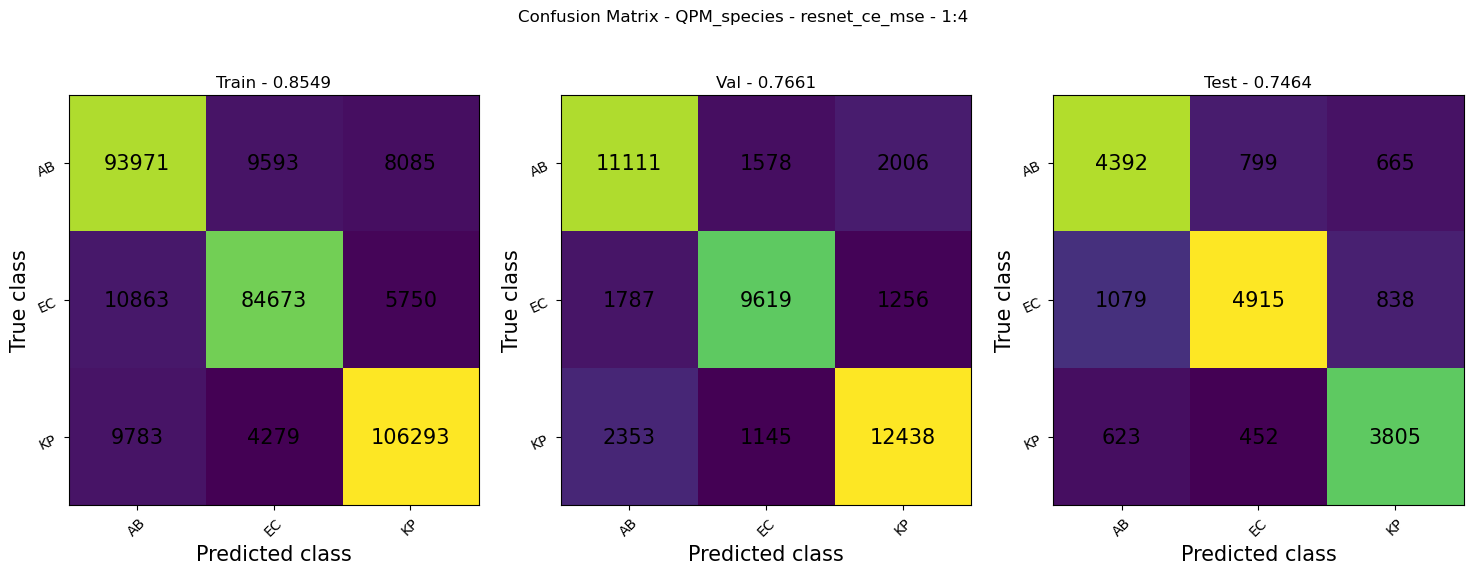

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(17568, 2) (2928, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(17568, 2) (2928, 2)


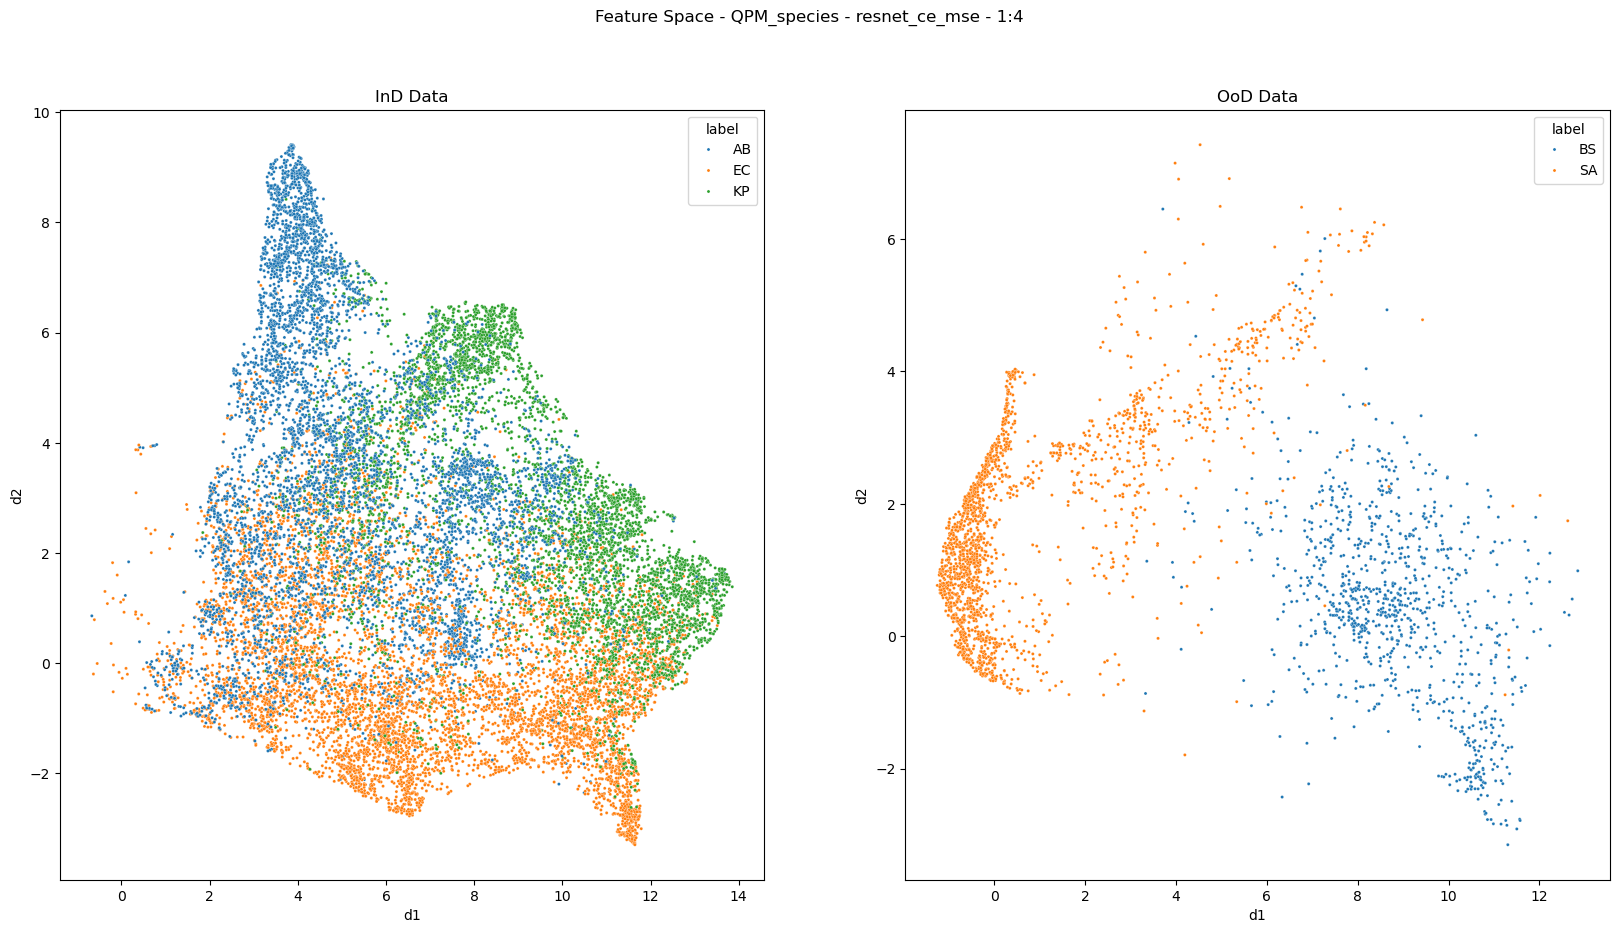

In [13]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

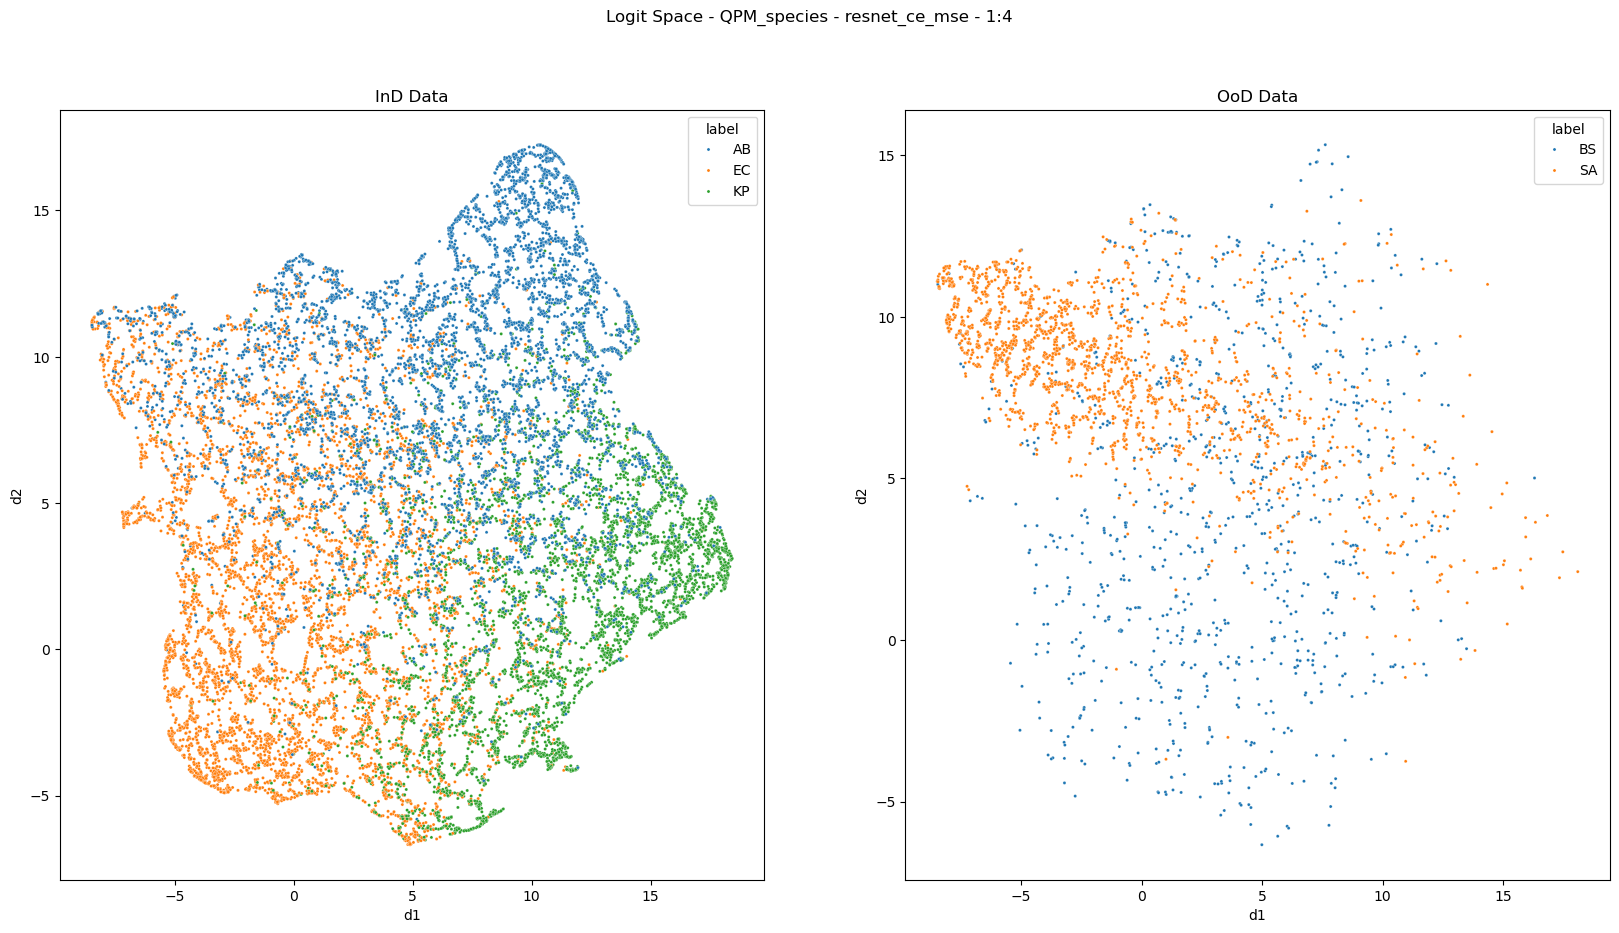

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

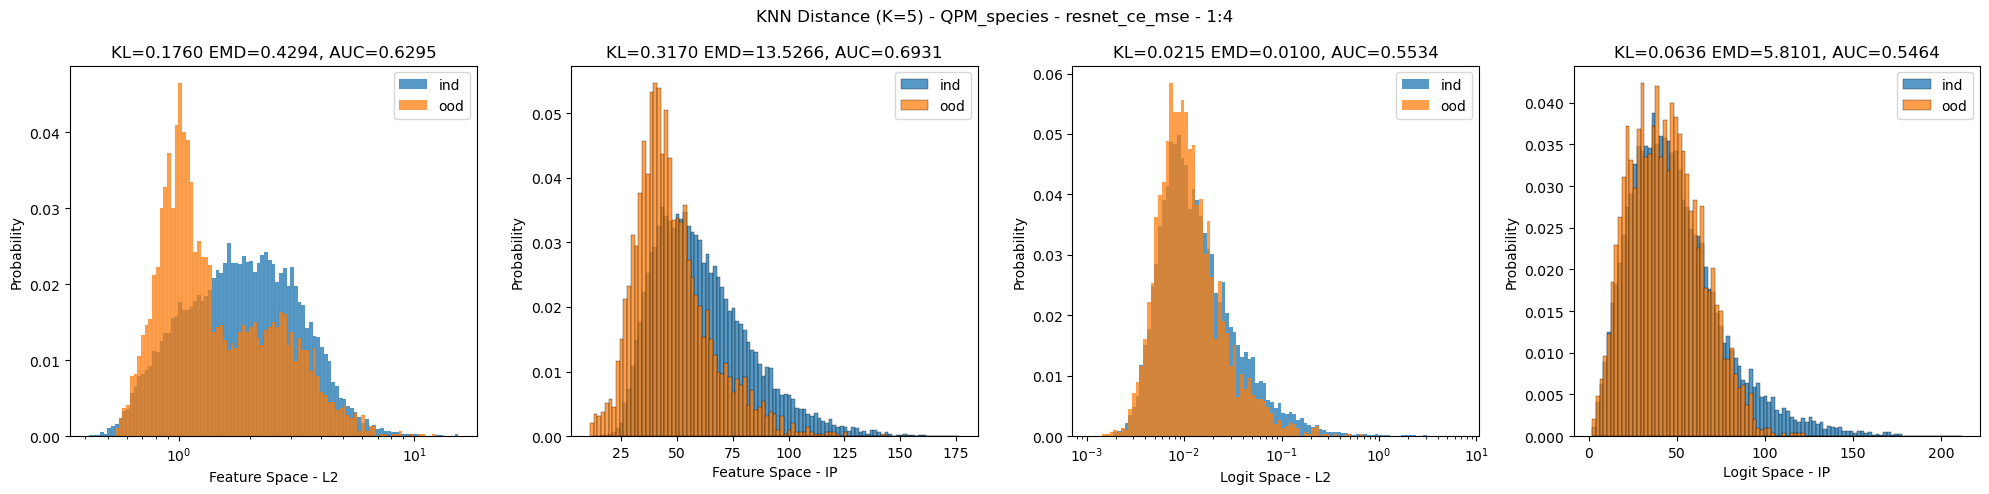

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

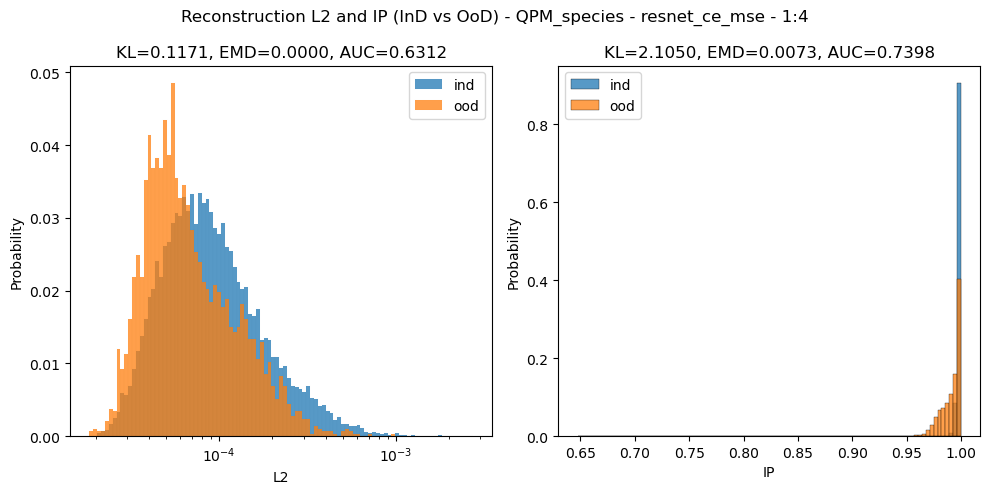

In [16]:
# plot reconstruction error of ind and ood data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_rcn.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_rcn.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

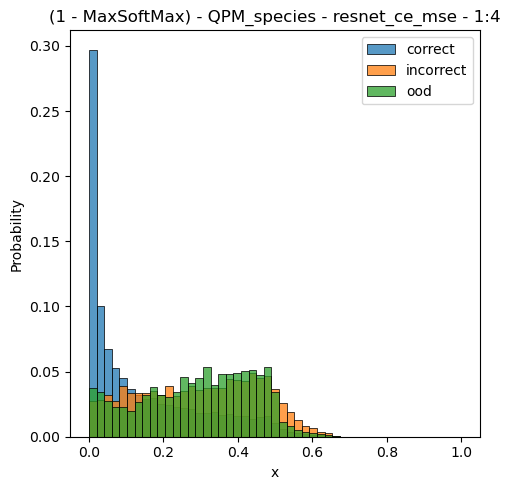

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [18]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)